In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%load_ext sql
%sql duckdb://

Connecting to 'duckdb://'

In [4]:
%%sql
DROP TABLE IF EXISTS bench;

CREATE TABLE
  IF NOT EXISTS bench (
    algorithm VARCHAR,
    prime UBIGINT,
    nBefore UBIGINT,
    nAfter UBIGINT,
    execTime UBIGINT,
    unchangedEntries FLOAT,
    allocatedBytes UBIGINT,
    allocations UBIGINT,
  );

COPY bench
FROM
  '.ignore.benchmark.csv';

Running query in 'duckdb://'

Count


In [5]:
%config SqlMagic.displaylimit = 10

In [6]:
%%sql
scaleUp <<
SELECT
  algorithm,
  prime,
  nBefore,
  nAfter,
  ROUND(AVG(unchangedEntries / 100), 4) AS average,
  ROUND(nBefore / nAfter, 4) AS maxTheory,
  ROUND(average / maxTheory, 4) AS stability,
  ROUND(AVG(execTime) / 1000000, 4) AS avgExecTimeMs,
FROM
  bench
WHERE
  nAfter > nBefore -- AND prime=23
GROUP BY
  algorithm,
  prime,
  nBefore,
  nAfter
ORDER BY
  stability DESC;

Running query in 'duckdb://'

In [7]:
%%sql
scaleDown <<
SELECT
  algorithm,
  prime,
  nBefore,
  nAfter,
  ROUND(AVG(unchangedEntries / 100), 4) AS average,
  ROUND(nAfter / nBefore, 4) AS maxTheory,
  ROUND(average / maxTheory, 4) AS stability,
  ROUND(AVG(execTime) / 1000000, 4) AS avgExecTimeMs,
FROM
  bench
WHERE
  nAfter < nBefore -- AND prime=23
GROUP BY
  algorithm,
  prime,
  nBefore,
  nAfter
ORDER BY
  stability DESC;

Running query in 'duckdb://'

In [8]:
scaleUp, scaleDown

(+--------------+-------+---------+--------+---------+-----------+-----------+---------------+
 |  algorithm   | prime | nBefore | nAfter | average | maxTheory | stability | avgExecTimeMs |
 +--------------+-------+---------+--------+---------+-----------+-----------+---------------+
 |   NaiveFib   |  307  |   255   |  299   |  0.8306 |   0.8528  |   0.974   |     0.4007    |
 | NaiveSimple  |  307  |   255   |  299   |  0.8306 |   0.8528  |   0.974   |      0.35     |
 |  RobustFib   | 65497 |    3    |   5    |  0.5526 |    0.6    |   0.921   |    39.3306    |
 | RobustSimple |  307  |   255   |  299   |  0.7336 |   0.8528  |   0.8602  |     0.5466    |
 |  RobustFib   |  307  |   255   |  299   |  0.7334 |   0.8528  |    0.86   |     0.7213    |
 | RobustSimple |   47  |    29   |   35   |  0.7032 |   0.8286  |   0.8487  |     0.1084    |
 |  RobustFib   |   47  |    29   |   35   |  0.6856 |   0.8286  |   0.8274  |     0.119     |
 |  RobustFib   |   23  |    3    |   5    |  0.48

In [9]:
column_names = [ "algorithm", "prime", "nBefore", "nAfter", "average", "maxTheory", "stability", "avgExecTimeMs" ]
data = [dict(zip(column_names, row)) for row in scaleUp]
data[0]

{'algorithm': 'NaiveFib',
 'prime': 307,
 'nBefore': 255,
 'nAfter': 299,
 'average': 0.8306,
 'maxTheory': 0.8528,
 'stability': 0.974,
 'avgExecTimeMs': 0.4007}

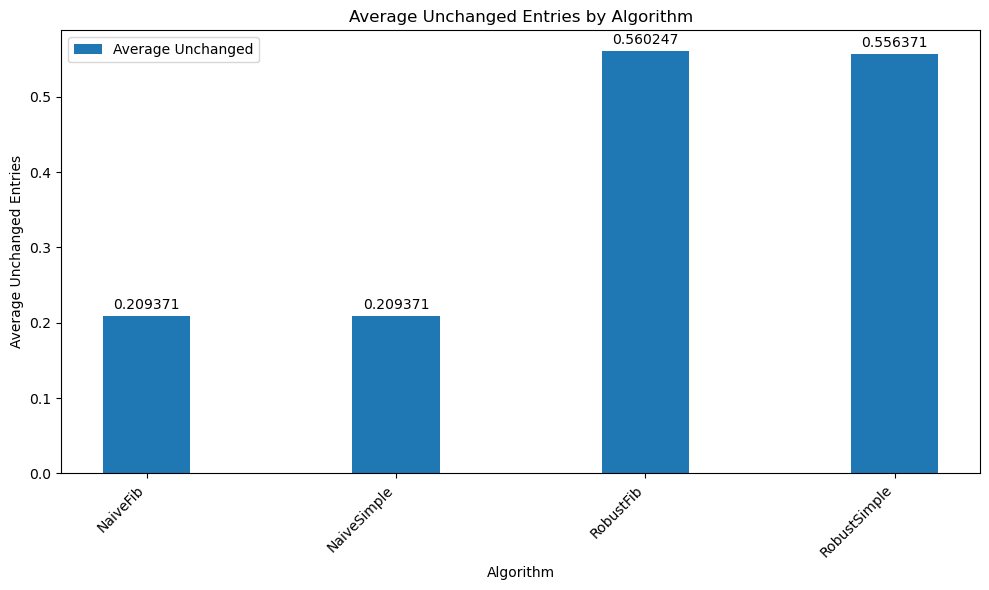

In [10]:
algorithms = [row['algorithm'] for row in data]
average_unchanged = [row['average'] for row in data]

unique_algorithms = sorted(list(set(algorithms)))
average_by_algorithm = {}
for algo in unique_algorithms:
    average_by_algorithm[algo] = np.mean([row['average'] for row in data if row['algorithm'] == algo])

x = np.arange(len(unique_algorithms))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, [average_by_algorithm[algo] for algo in unique_algorithms], width, label='Average Unchanged')

ax.set_ylabel('Average Unchanged Entries')
ax.set_xlabel('Algorithm')
ax.set_title('Average Unchanged Entries by Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(unique_algorithms, rotation=45, ha='right')
ax.legend()

ax.bar_label(rects1, padding=3)

fig.tight_layout()
plt.show()

We can observe that both RobustFib and RobustSimple algorithms performs well.
The 23 and 47 primes are outperforming larger and more expansive ones.


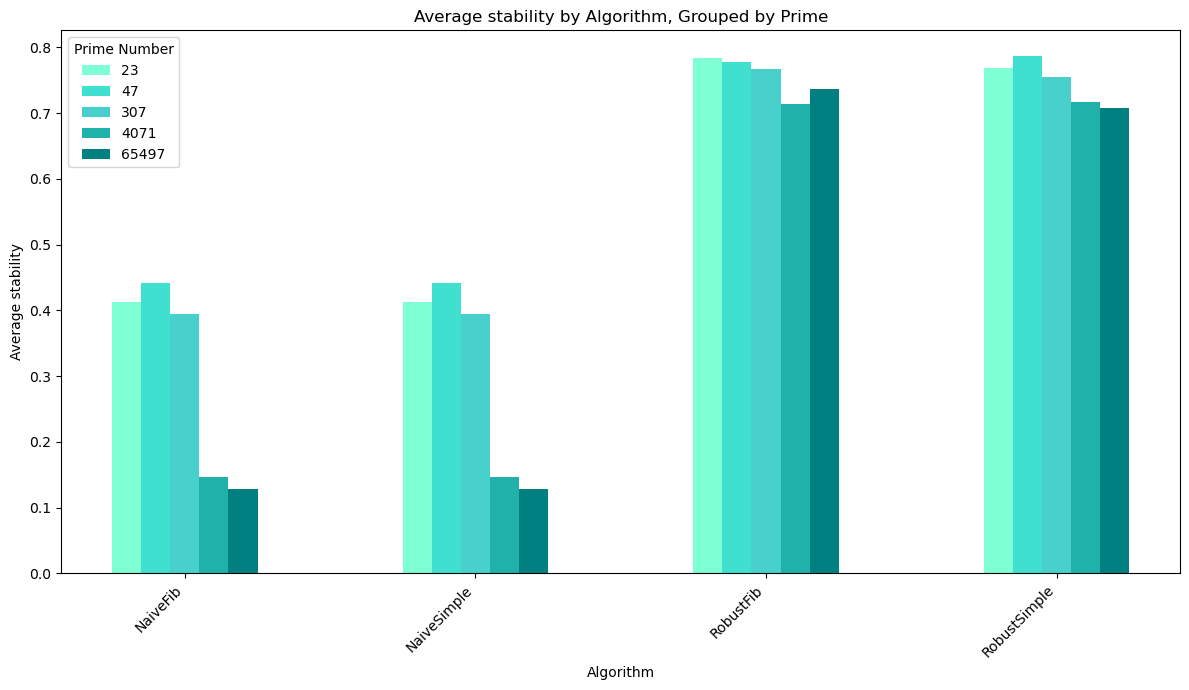

In [11]:
unique_primes = sorted(list(set([row['prime'] for row in data])))
unique_algorithms = sorted(list(set([row['algorithm'] for row in data])))

x = np.arange(len(unique_algorithms))
width = 0.9 / (len(unique_primes) + len(unique_algorithms))  # Adjust width based on the number of prime numbers

fig, ax = plt.subplots(figsize=(12, 7))
# https://i.sstatic.net/lFZum.png
colors = ["aquamarine", "turquoise", "mediumturquoise", "lightseagreen", "teal" ]

for i, algo in enumerate(unique_algorithms):
    for j, prime in enumerate(unique_primes):
        mean_stability = np.mean([row['stability'] for row in data if row['algorithm'] == algo and row['prime'] == prime])
        # Handle cases where an algorithm might not have data for a specific prime
        if (mean_stability):
            offset = (j) * width
            ax.bar(i + offset, mean_stability, width, label=prime, color=colors[j])

ax.set_ylabel('Average stability')
ax.set_xlabel('Algorithm')
ax.set_title('Average stability by Algorithm, Grouped by Prime')
ax.set_xticks(x + width * (len(unique_primes) - 1) / 2)
ax.set_xticklabels(unique_algorithms, rotation=45, ha='right')
ax.legend(unique_primes, title='Prime Number')

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())


fig.tight_layout()

print("We can observe that both RobustFib and RobustSimple algorithms performs well.")
print("The 23 and 47 primes are outperforming larger and more expansive ones.")
plt.show()

In [12]:
# Max theoretical value:
# - if Before > After: maxTheoretical= After / Before
# - if After > Before: maxTheoretical= Before / After
# Stability := avg / maxTheoretical